# Testing Human VAE

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import os
import pbdlib as pbd

import networks
import config
from utils import *
import dataloaders

torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# print("| Model | Z Dim | MSE |")
# print("|:-----:|:-----:|:----:|")
# for z_dim in [3,5,8,10]:
# 	for model_types in ['vae','mild']:
# # if True:
# # 	if True:	
# 		# ckpt = 'logs/2023/cross_kld_correct/models/final.pth' 
# 		ckpt = f'logs/2023/ablation_{model_types}/z{z_dim}/trial0/models/final.pth' # input()

# 		dirname = os.path.dirname(ckpt)
# 		hyperparams = np.load(os.path.join(dirname,'hyperparams.npz'), allow_pickle=True)
# 		args = hyperparams['args'].item()
# 		ckpt = torch.load(ckpt)

# 		model = getattr(networks, args.model)(**(hyperparams['ae_config'].item().__dict__)).to(device)
# 		model.load_state_dict(ckpt['model'])
# 		model.eval()
# 		z_dim = model.latent_dim
# 		if model.window_size == 1:
# 			nb_dim = 4*model.latent_dim
# 		else:
# 			nb_dim = 2*model.latent_dim
# 		dataset = getattr(dataloaders, args.dataset)
# 		if model.window_size ==1:
# 			train_iterator = DataLoader(dataset.SequenceDataset(args.src, train=True), batch_size=1, shuffle=True)
# 			test_iterator = DataLoader(dataset.SequenceDataset(args.src, train=False), batch_size=1, shuffle=True)
# 		else:
# 			train_iterator = DataLoader(dataset.SequenceWindowDataset(args.src, train=True, window_length=model.window_size), batch_size=1, shuffle=True)
# 			test_iterator = DataLoader(dataset.SequenceWindowDataset(args.src, train=False, window_length=model.window_size), batch_size=1, shuffle=True)
# 		hsmm = ckpt['hsmm']
# 		# z_dim = model.latent_dim
		
# 		# for a in range(len(train_iterator.dataset.actidx)):
# 		# 	s = train_iterator.dataset.actidx[a]
# 		# 	z_encoded = []
# 		# 	for j in range(s[0], s[1]):
# 		# 	# for j in np.random.randint(s[0], s[1], 12):
# 		# 		x, label = train_iterator.dataset[j]
# 		# 		assert np.all(label == a)
# 		# 		x = torch.Tensor(x).to(device)
# 		# 		seq_len, dims = x.shape
# 		# 		x = torch.concat([x[None, :, :dims//2], x[None, :, dims//2:]]) # x[0] = Agent 1, x[1] = Agent 2
				
# 		# 		zpost_samples = model(x, encode_only=True)
# 		# 		if model.window_size == 1:
# 		# 			z1_vel = torch.diff(zpost_samples[0], prepend=zpost_samples[0][0:1], dim=0)
# 		# 			z2_vel = torch.diff(zpost_samples[1], prepend=zpost_samples[1][0:1], dim=0)
# 		# 			z_encoded.append(torch.concat([zpost_samples[0], z1_vel, zpost_samples[1], z2_vel], dim=-1).detach().cpu().numpy()) # (num_trajs, seq_len, 2*z_dim)
# 		# 		else:
# 		# 			z_encoded.append(torch.concat([zpost_samples[0], zpost_samples[1]], dim=-1).detach().cpu().numpy()) # (num_trajs, seq_len, 2*z_dim)
# 		# 	hsmm[a].init_hmm_kbins(z_encoded)
# 		# 	hsmm[a].em(z_encoded)

# 		predictions = []
# 		mse_error = []
# 		# for a in range(len(train_iterator.dataset.actidx)):
# 		# 	mse_error[a] = []
# 		for i, x in enumerate(test_iterator):
# 			x, label = x
# 			x = x[0]
# 			label = int(label[0])
# 			x = torch.Tensor(x).to(device)
# 			seq_len, dims = x.shape
# 			x = torch.concat([x[None, :, :dims//2], x[None, :, dims//2:]]) # x[0] = Agent 1, x[1] = Agent 2
			
# 			alpha_hsmm, _, _, _, _ = hsmm[label].compute_messages(marginal=[], sample_size=seq_len)
# 			if np.any(np.isnan(alpha_hsmm)):
# 				print('Alpha Nan')
# 				alpha_hsmm = forward_variable(hsmm[label], n_step=seq_len)

# 			seq_alpha = alpha_hsmm.argmax(0)

# 			x_gen, zpost_samples, zpost_dist = model(x)
				
# 			if model.window_size >1:
# 				z2, sigma2 = hsmm[label].condition(zpost_dist.mean[0].detach().cpu().numpy(), zpost_dist.covariance_matrix[0].detach().cpu().numpy(), dim_in=slice(0, z_dim), dim_out=slice(z_dim, 2*z_dim))
# 			else:
# 				z1_vel = torch.diff(zpost_dist.mean[0], prepend=zpost_dist.mean[0][0:1], dim=0)
# 				z2, sigma2 = hsmm[label].condition(torch.concat([zpost_dist.mean[0], z1_vel], dim=-1).detach().cpu().numpy(), zpost_dist.covariance_matrix[0].detach().cpu().numpy(), dim_in=slice(0, 2*z_dim), dim_out=slice(2*z_dim, 3*z_dim))
# 			x2_gen = model._output(model._decoder(torch.Tensor(z2).to(device)))
# 			x1_gen = x_gen[0]
# 			x_gen = torch.concat([x1_gen[None], x2_gen[None]])
# 			x2_gen = x2_gen.reshape((x2_gen.shape[0], 40, 4 ,3))
# 			x2_gt = x[1].reshape((x[1].shape[0], 40, 4 ,3))
			
# 			# mse_error[label].append(F.mse_loss(x[1], x2_gen, reduction='sum').detach().cpu().numpy())
# 			mse_i = ((x2_gen - x2_gt)**2).detach().cpu().numpy().sum(-1).sum(-1).mean(-1)
# 			mse_error += mse_i.tolist()
# 		print(f"| {model_types} | {z_dim} | {np.mean(mse_error):.4e} ± {np.std(mse_error):.4e} |")
# 		# print(f'MSE: {np.sum(mse_error)}')
# 		break
# 	break


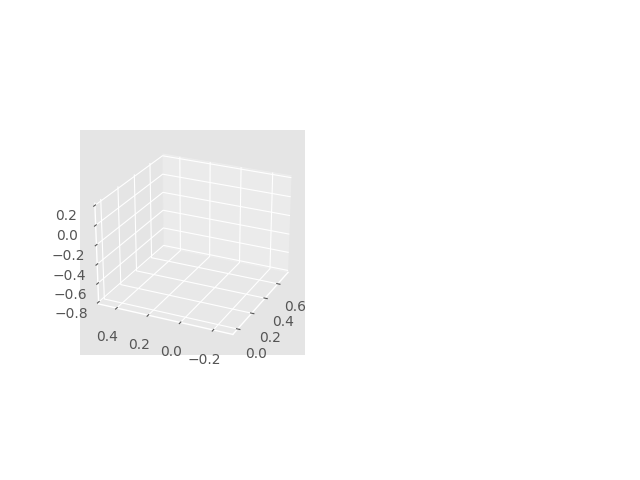

Task exception was never retrieved
future: <Task finished name='Task-6' coro=<update() done, defined at /tmp/ipykernel_1149508/899354900.py:10> exception=AttributeError("'numpy.ndarray' object has no attribute 'detach'")>
Traceback (most recent call last):
  File "/tmp/ipykernel_1149508/899354900.py", line 20, in update
    x1_gt = x[0].reshape((seq_len, 40, 4, 3)).detach().cpu().numpy()
AttributeError: 'numpy.ndarray' object has no attribute 'detach'


In [5]:
%matplotlib widget
import matplotlib.pyplot as plt
from utils import *
import asyncio

from dataloaders.buetepage import SequenceWindowDataset
test_iterator = DataLoader(SequenceWindowDataset('data/buetepage/traj_data_new.npz', train=False), batch_size=1, shuffle=False)

fig, ax = prepare_axis()
async def update():
    global ax, x2_gen
    for i, x in enumerate(test_iterator):
    # if True:
        x, label = x
        x = x[0]
        print(x.shape)
        seq_len, dims = x.shape
        print(seq_len, dims)
        x = torch.concat([x[None, :, :dims//2], x[None, :, dims//2:]]) # x[0] = Agent 1, x[1] = Agent 2
        x1_gt = x[0].reshape((seq_len, 40, 4, 3)).detach().cpu().numpy()
        x2_gt = x[1].reshape((seq_len, 40, 4, 3)).detach().cpu().numpy()
        # x1_gen = x_gen[0].reshape((seq_len, 40, 4, 3)).detach().cpu().numpy()
        # x2_gen = x2_gen.reshape((seq_len, 40, 4, 3)).detach().cpu().numpy()
        for frame_idx in range(0,seq_len,10):
            ax = reset_axis(ax)
            ax = visualize_skeleton(ax, x1_gt[frame_idx], markerfacecolor='r', linestyle='-', alpha=0.5)
            
            x2_gt[frame_idx, ..., 0] = 0.7 - x2_gt[frame_idx, ..., 0]
            x2_gt[frame_idx, ..., 1] = 0.2 - x2_gt[frame_idx, ..., 1]
            # x2_gen[frame_idx, ..., 0] = 0.7 - x2_gen[frame_idx, ..., 0]
            # x2_gen[frame_idx, ..., 1] = 0.2 - x2_gen[frame_idx, ..., 1]

            ax = visualize_skeleton(ax, x2_gt[frame_idx], markerfacecolor='b', linestyle='-', alpha=0.5)
            # ax = visualize_skeleton(ax, x2_gen[frame_idx], markerfacecolor='g', linestyle='--', alpha=0.2)
            
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
            await asyncio.sleep(0.001)
loop = asyncio.get_event_loop()
loop.create_task(update());
